In [224]:
import os.path
from os import path
import requests
import tarfile
import shutil

In [225]:
PATH_TO_RESOURCES = "../resources"

## Fonction init_resources

**param force** : 1 si l'on veut télécharger la donnée m

1. Controlle l'existence d'un dossier de **resources** situé à la racine du projet
2. Si ce dossier existe et que **force == 0** alors il n'y a rien à faire
3. Sinon, le dossier est crée, l'archive est téléchargée et décompréssée puis supprimée.

In [226]:
# Check if a local resources file exists.
# If not or force=True, creates the files and uploads data.
def init_resources(force = False):
    PATH_TO_RESOURCES = "../resources"
    
    if (path.exists(PATH_TO_RESOURCES) and path.isdir(PATH_TO_RESOURCES)):
        if not force:
            print("Folder 'resources' found.")
            return
        else:
            shutil.rmtree(PATH_TO_RESOURCES)
    
    # Create folder
    os.mkdir(PATH_TO_RESOURCES)
    print("[1/4] Folder '../resources' created.")
    
    # Download data
    url_data = 'https://www.lrde.epita.fr/~jchazalo/SHARE/dobble-symbols-dataset-train.tar.gz'
    url_dobble_img = 'https://boardgamereview.co.uk/wp-content/uploads/2020/02/Dobble-cards-pile-1.png'
    TAR_PATH = os.path.join(PATH_TO_RESOURCES, 'dobble-symbols-dataset-train.tar.gz')
    IMG_PATH = os.path.join(PATH_TO_RESOURCES, 'dobble_ref.png')
    response = requests.get(url_data, stream=True)
    if response.status_code == 200:
        with open(TAR_PATH, 'wb') as f:
            f.write(response.raw.read())
    response = requests.get(url_dobble_img, stream=True)
    if response.status_code == 200:
        with open(IMG_PATH, 'wb') as f:
            f.write(response.raw.read())
            print("[2/4] Resources files uploaded.")
    
    # Extract from tar
    tar = tarfile.open(TAR_PATH)
    tar.extractall(PATH_TO_RESOURCES) # specify which folder to extract to
    tar.close()
    print("[3/4] Resources files extracted.")
    
    # Delete dowloaded tar
    os.remove(TAR_PATH)
    print("[4/4] Tarball removed.")

In [227]:
init_resources(0)

Folder 'resources' found.


## Chargement des données
1. Récupération des données d'entrainement
2. Calcul des masques
3. Extraction des pixels à utiliser dans chaque image

In [228]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [229]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

In [230]:
# define a function to compute the mask of a bubble
def symbol2mask(symbol):
    return np.sum(symbol, axis=2) < 255 * 3

In [231]:
symbol_files = !ls $PATH_TO_RESOURCES/**/c*.png  | sort
symbol_files

['../resources/train/01/c01_s00.png',
 '../resources/train/01/c04_s01.png',
 '../resources/train/01/c07_s03.png',
 '../resources/train/01/c30_s03.png',
 '../resources/train/01/c34_s03.png',
 '../resources/train/02/c01_s01.png',
 '../resources/train/02/c09_s00.png',
 '../resources/train/02/c14_s05.png',
 '../resources/train/02/c32_s00.png',
 '../resources/train/02/c53_s03.png',
 '../resources/train/03/c03_s04.png',
 '../resources/train/03/c37_s00.png',
 '../resources/train/03/c47_s00.png',
 '../resources/train/03/c50_s01.png',
 '../resources/train/03/c51_s01.png',
 '../resources/train/04/c01_s03.png',
 '../resources/train/04/c22_s05.png',
 '../resources/train/04/c31_s02.png',
 '../resources/train/04/c39_s02.png',
 '../resources/train/04/c46_s04.png',
 '../resources/train/05/c01_s04.png',
 '../resources/train/05/c12_s07.png',
 '../resources/train/05/c23_s01.png',
 '../resources/train/05/c29_s02.png',
 '../resources/train/05/c38_s03.png',
 '../resources/train/06/c01_s05.png',
 '../resourc

In [232]:
symbols = [load_image(symbol_file) for symbol_file in symbol_files]

In [233]:
symbols_masks = [symbol2mask(symbol) for symbol in symbols]

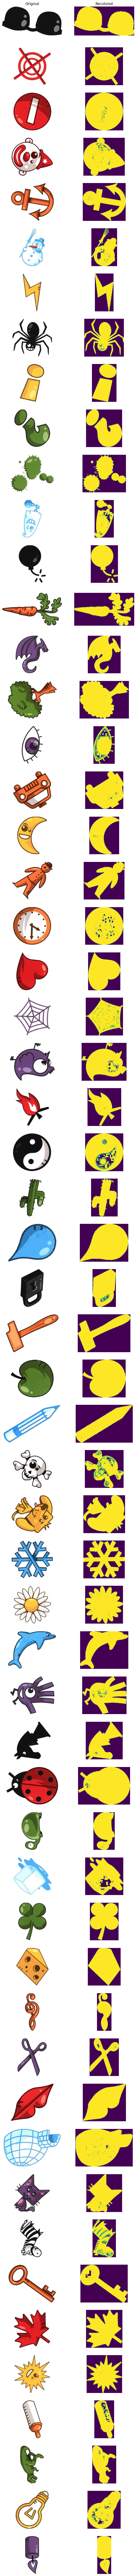

In [234]:
plt.figure(figsize=(8,16 * 10))
for ii in range(57):
    plt.subplot(57,2,1+2*ii)
    plt.imshow(symbols[ii * 5])
    plt.axis("off")
    if ii == 0:
        plt.title("Original")
    plt.subplot(57,2,2+2*ii)
    plt.imshow(symbols_masks[ii * 5])
    plt.axis("off")
    if ii == 0:
        plt.title("Recolored")

In [235]:
sample_pixels = symbols[0][symbols_masks[0]]
for i in range(1, len(symbols)):
    sample_pixels = np.concatenate((sample_pixels, symbols[i][symbols_masks[i]]), axis=0)

sample_pixels.shape, sample_pixels.dtype

((5848412, 3), dtype('uint8'))

In [236]:
import re

In [237]:
symbols_labels = np.array([re.search(".+/([0-9]{2})/.+\.png", symbol_file).group(1) for symbol_file in symbol_files])

## Réduction des couleurs

In [238]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [239]:
def find_and_plot_cluster_centers(clusters_nb):
    # Train kmeans
    kmeans = MiniBatchKMeans(clusters_nb, random_state=42)
    kmeans.fit(sample_pixels)
    
    # Create the LUT
    color_lut = np.uint8(kmeans.cluster_centers_)
    
    # Sort it by hue
    hue_lut = cv2.cvtColor(color_lut.reshape(1,color_lut.shape[0], color_lut.shape[1]), cv2.COLOR_BGR2HSV)[:, :, 0]
    indices = hue_lut.argsort(axis=None)
    color_lut_sorted = color_lut[indices]
    
    # Plot it
    plt.bar(np.arange(len(color_lut)), 
        np.ones(len(color_lut)), 
        color=color_lut_sorted/255)
    
    return kmeans, color_lut

CPU times: user 1min 27s, sys: 7.02 s, total: 1min 34s
Wall time: 28.1 s


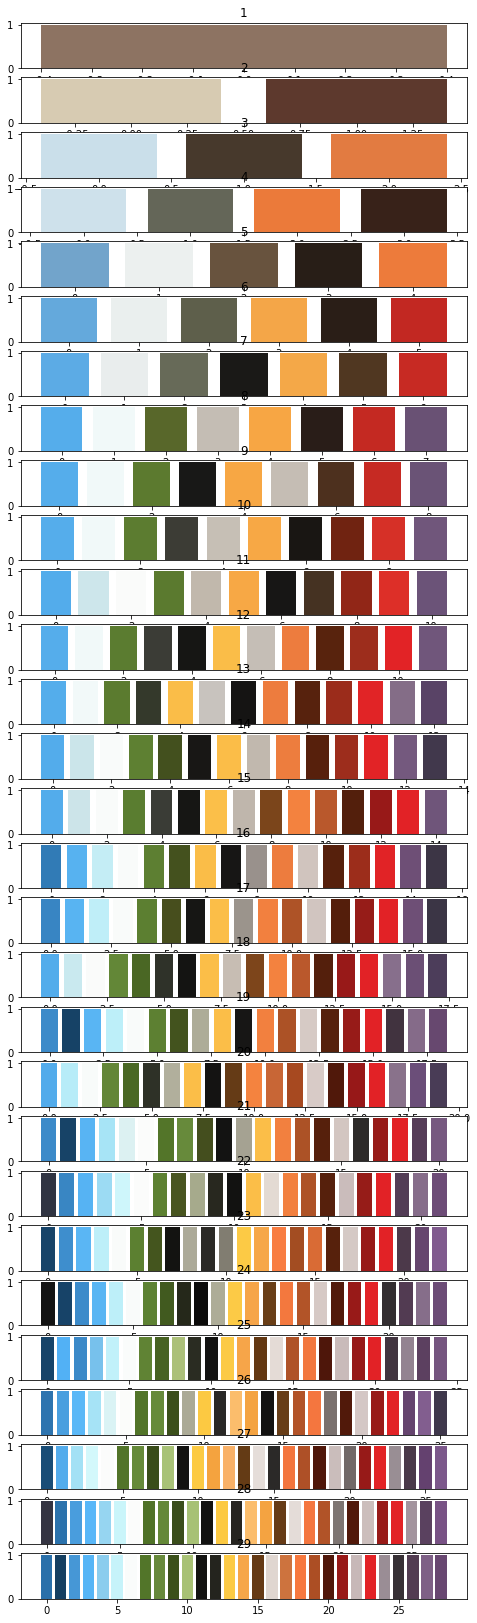

In [240]:
%%time
# let us display the images
plt.figure(figsize=(8,30))
max_clusters_nb = 30
variances = np.zeros(max_clusters_nb - 1)

for ii in range(1, max_clusters_nb):
    plt.subplot(max_clusters_nb, 1, ii)
    
    kmeans, color_lut = find_and_plot_cluster_centers(ii)
    plt.title(ii)
    
    variances[ii - 1] = kmeans.inertia_

In [241]:
from matplotlib.ticker import MaxNLocator

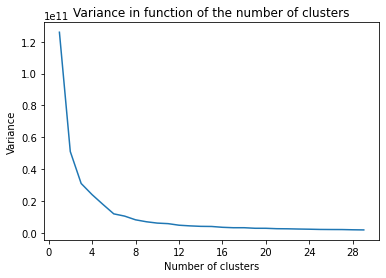

In [242]:
plt.plot(np.arange(1, max_clusters_nb), variances)
plt.xlabel("Number of clusters")
plt.ylabel("Variance")
plt.title("Variance in function of the number of clusters")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

6 seems to be a good choice.

In [243]:
def recolor_masked(symbol, clusterer, color_lut):
    symbol_mask = symbol2mask(symbol)
    recolored = np.ones_like(symbol) * 255
    recolored[symbol_mask] = color_lut[np.uint8(clusterer.predict(symbol[symbol_mask]))]
    return recolored

In [244]:
def recolor_masked_know(symbol, symbol_mask, clusterer, color_lut):
    recolored = np.ones_like(symbol) * 255
    recolored[symbol_mask] = color_lut[np.uint8(clusterer.predict(symbol[symbol_mask]))]
    return recolored

In [245]:
def recolor_unmasked(image, clusterer, color_lut):
    return color_lut[np.uint8(clusterer.predict(image.reshape((image.shape[0] * image.shape[1], image.shape[2]))))].reshape((image.shape[0], image.shape[1], image.shape[2]))

CPU times: user 2.01 s, sys: 172 ms, total: 2.19 s
Wall time: 609 ms


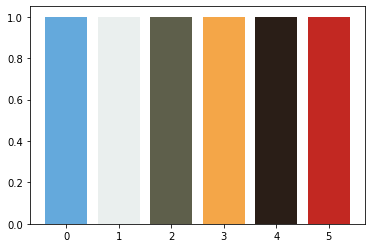

In [246]:
%%time
# reduce the color of all bubbles
# This is exactly what we did for the full poster, but applied to each bubble AND keeping background as black.
kmeans, color_lut = find_and_plot_cluster_centers(6)
symbols_quant = [recolor_masked_know(symbols[i], symbols_masks[i], kmeans, color_lut) for i in range(len(symbols))]

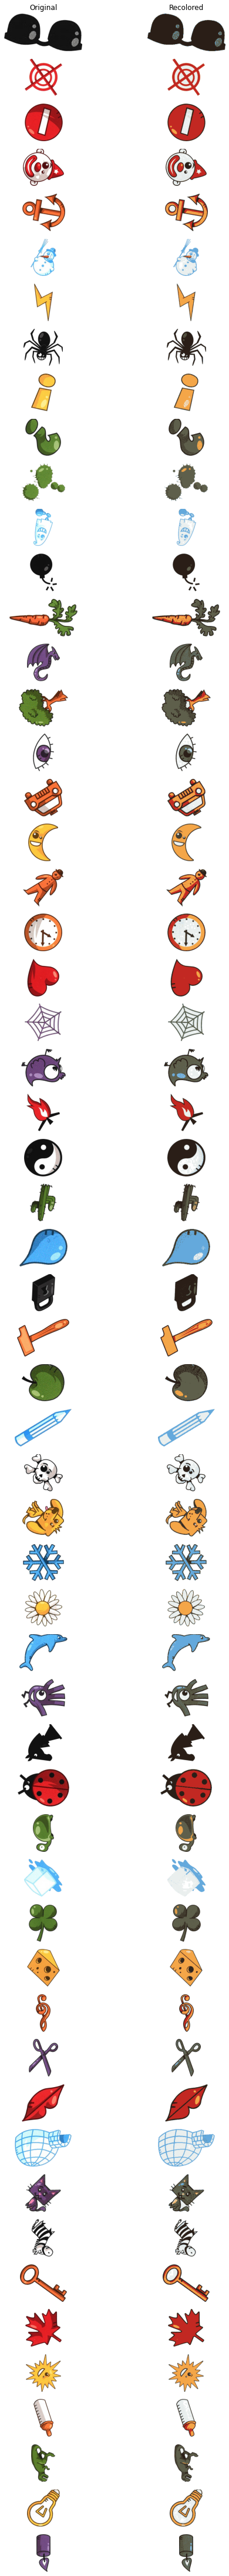

In [247]:
# let us display the images
plt.figure(figsize=(8,16 * 5))
for ii in range(57):
    plt.subplot(57,2,1+2*ii)
    plt.imshow(symbols[ii * 5])
    plt.axis("off")
    if ii == 0:
        plt.title("Original")
    plt.subplot(57,2,2+2*ii)
    plt.imshow(symbols_quant[ii * 5])
    plt.axis("off")
    if ii == 0:
        plt.title("Recolored")

On peut remarquer que le vert et le violet ce confonde.

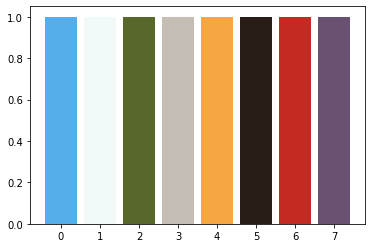

In [248]:
kmeans, color_lut = find_and_plot_cluster_centers(8)
symbols_quant = [recolor_masked_know(symbols[i], symbols_masks[i], kmeans, color_lut) for i in range(len(symbols))]

Pour 8 cluster le violet apparaît.

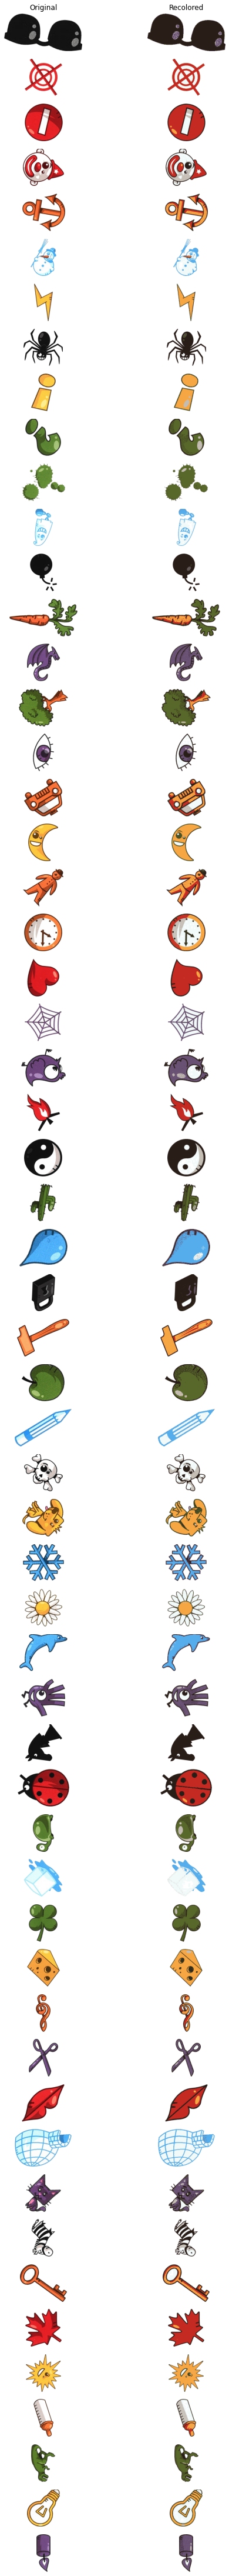

In [249]:
plt.figure(figsize=(8,16 * 5))
for ii in range(57):
    plt.subplot(57,2,1+2*ii)
    plt.imshow(symbols[ii * 5])
    plt.axis("off")
    if ii == 0:
        plt.title("Original")
    plt.subplot(57,2,2+2*ii)
    plt.imshow(symbols_quant[ii * 5])
    plt.axis("off")
    if ii == 0:
        plt.title("Recolored")

On observe des résultats plus satisfaisant qu'avec 6 clusters, on va donc en utiliser 8.

## Normalisation  des tailles des images
On fait en sorte que toutes les images ait la même tailles pour utiliser les images elles-mêmes en tant que descripteurs.

In [250]:
def find_bounding_shape(images):
    max_h, max_w = 0, 0
    for img in images:
        h = img.shape[0]
        w = img.shape[1]
        if w > max_w:
            max_w = w
        if h > max_h:
            max_h = h
            
    return max_h, max_w, 3

In [251]:
def normalize_image(image, bounding_shape):
    normalized = np.zeros(bounding_shape)
    bound_h, bound_w, _ = bounding_shape
    max_h = bound_w if bound_w == image.shape[0] else image.shape[0]
    max_w = bound_h if bound_h == image.shape[1] else image.shape[1]
    normalized[:max_h,:max_w,:] = image[:max_h,:max_w,:]
    return normalized

In [252]:
a = np.ones((2,1,3))
b = np.ones((1, 3, 3))
bound_shape = find_bounding_shape([a,b])
a, b, normalize_image(a, bound_shape)

(array([[[1., 1., 1.]],
 
        [[1., 1., 1.]]]),
 array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]]),
 array([[[1., 1., 1.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[1., 1., 1.],
         [0., 0., 0.],
         [0., 0., 0.]]]))

In [253]:
bound_shape = find_bounding_shape(symbols_quant)
symbols_train = np.array([normalize_image(img, bound_shape).flatten() for img in symbols_quant], dtype=int)
symbols_train.shape, symbols_labels.shape

((285, 499092), (285,))

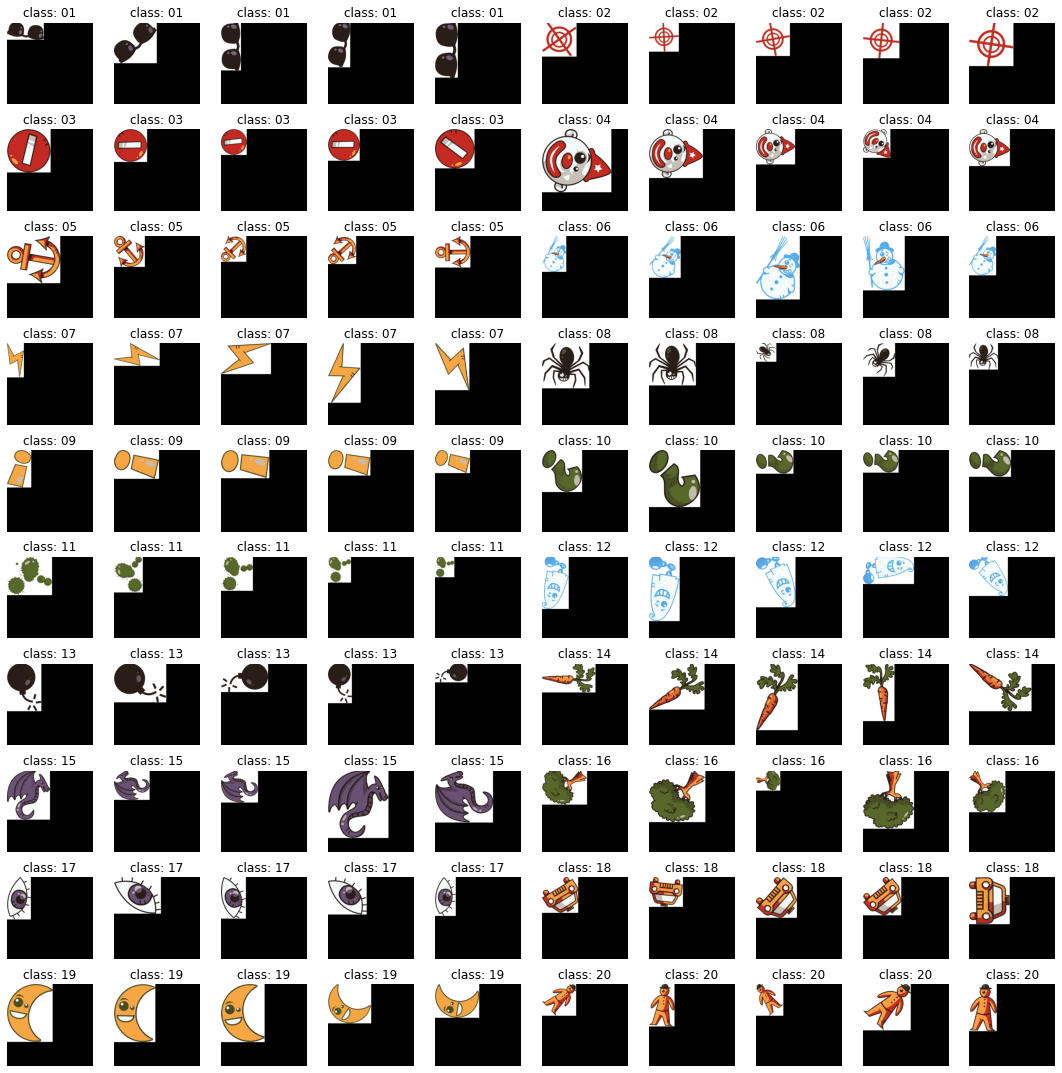

In [254]:
plt.figure(figsize=(15,15))
for ii in range(100):
    image = symbols_train[ii]
    label = symbols_labels[ii]
    plt.subplot(10,10,ii+1)
    plt.imshow(image.reshape(bound_shape), cmap='gray')
    plt.title(f"class: {label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Dummy classifier

In [255]:
from sklearn.dummy import DummyClassifier

In [259]:
dummy_clf  = DummyClassifier()
dummy_clf.fit(symbols_train, symbols_labels)
prediction = dummy_clf.predict(symbols_train)

## Evaluation des résultats

In [260]:
def success_rate(prediction, expected):
    success = 0
    for i in range(len(prediction)):
        if prediction[i] == expected[i]:
            success += 1
    
    return success / len(prediction)

In [262]:
success_rate(prediction, symbols_labels)

0.017543859649122806

## Exportation des résultats

In [257]:
def dry_exporter(path: str, fileNames: list[str], results: list[int]):
    if len(fileNames) != len(results):
        raise ValueError("Number of files do not match number of results")
    
    fileContent = ""
    for i in range(len(fileNames)):
        fileContent += f"{fileNames[i]},{results[i]}\n"
    
    print(fileContent)

## Pipeline finale

In [258]:
class Pipeline:
    def __init__(self, initiator, extractors, classifier, exporter):
        self.initiator = initiator
        if extractors is not list:
            self.extractors = [extractors]
        else:
            self.extractors = extractors
        self.classifier = classifier
        self.exporter = exporter